In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

data = pd.read_csv("preprocessed_apartment_rentals_no_state_dummies_nocluster.csv")

# Features und Ziel
X = data.drop(columns=["price"])
y = data["price"]
y = np.log1p(y)  # Log-Transformation


# Regression

# Ridge Regression

In [8]:
from Nested_CV_targetEncoding import NestedCVRegressorWithTargetEncoding

In [9]:
from sklearn.linear_model import Ridge
import numpy as np
ridge_params = {"alpha": np.logspace(-3, 3, 10)}

ridge_cv = NestedCVRegressorWithTargetEncoding(model = Ridge(), param_grid = ridge_params, encode_cols=["state", "cityname"])
ridge_cv.run(X, y, output=True)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 1/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 0.199s | Outer R²: 0.656 | MSE: 0.062
Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

In [31]:
number_outer_cv_splits = 5
model_evaluation = pd.DataFrame({"Fold": range(1, number_outer_cv_splits+1)})
model_evaluation['Modell'] = ['Ridge_target_encoding'] * number_outer_cv_splits
model_evaluation['R_2'] = ridge_cv.get_r2_scores()
model_evaluation['MSE'] = ridge_cv.get_mse_scores()
model_evaluation["runtime"] = ridge_cv.get_fit_times()
model_evaluation

,Fold,Modell,R_2,MSE,runtime
0,1,Ridge_target_encoding,0.683759,0.056749,0.195295
1,2,Ridge_target_encoding,0.673521,0.057687,0.467688
2,3,Ridge_target_encoding,0.672133,0.058887,0.254827
3,4,Ridge_target_encoding,0.674815,0.057494,0.156138
4,5,Ridge_target_encoding,0.680435,0.056576,0.169802


In [32]:
model_evaluation.to_pickle('benchmarking/Ridgeregression_targetencoding.pkl')

In [33]:
from sklearn.linear_model import Lasso
import numpy as np
lasso_params = {"alpha": np.logspace(-3, 3, 10)}

lasso_cv = NestedCVRegressorWithTargetEncoding(model = Lasso(), param_grid = lasso_params, encode_cols=["state", "cityname"])
lasso_cv.run(X, y, output=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 1/5 | Best Params: {'model__alpha': np.float64(0.001)} | Fit Time: 0.274s | Outer R²: 0.682 | MSE: 0.057
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 2/5 | Best Params: {'model__alpha': np.float64(0.001)} | Fit Time: 0.252s | Outer R²: 0.671 | MSE: 0.058
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 3/5 | Best Params: {'model__alpha': np.float64(0.001)} | Fit Time: 0.381s | Outer R²: 0.670 | MSE: 0.059
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 4/5 | Best Params: {'model__alpha': np.float64(0.001)} | Fit Time: 0.251s | Outer R²: 0.672 | MSE: 0.058
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 5/5 | Best Params: {'model__alpha': np.float64(0.001)} | Fit Time: 0.261s | Outer R²: 0.678 | MSE: 0.057


# Analyse
Welche Preise werden gut, welche schlechter vorhergesagt?

Final Alpha: 46.41588833612773
Test MSE: 0.05674930284566956
Test R²: 0.6837587007580264


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.80847e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\User\AppData\Local\Temp\ipykernel_8468\2286581761.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


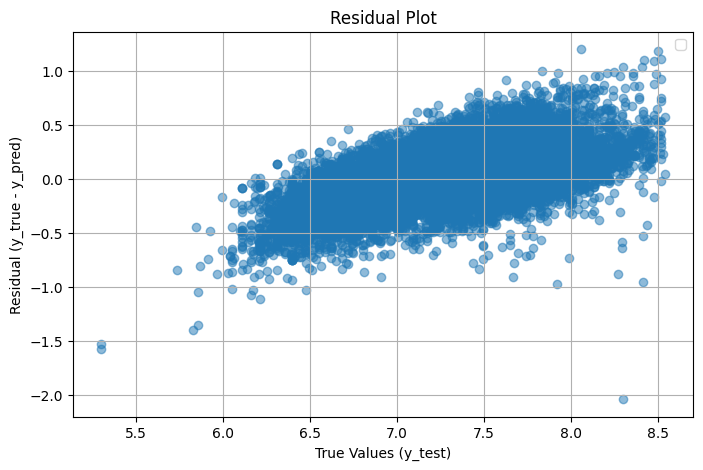

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder

# ---------------------------------------------------------
# 1️⃣ Finales Alpha aus Nested CV (von dir vorher berechnet)
# ---------------------------------------------------------
best_parameters = ridge_cv.get_best_params()   # liefert Liste von dicts

alpha_values = [float(list(p.values())[0]) for p in best_parameters]
final_alpha = np.median(alpha_values)
print("Final Alpha:", final_alpha)

# ---------------------------------------------------------
# 2️⃣ Train/Test Split
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# ---------------------------------------------------------
# 3️⃣ Target Encoding korrekt (nur auf TRAIN fitten!)
# ---------------------------------------------------------
te = TargetEncoder(cols=["state", "cityname"])   # deine kategorische Spalte

# Auf TRAIN fitten
te.fit(X_train[["state", "cityname"]], y_train)

# Transformieren
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

X_train_enc[["cityname", "state"]] = te.transform(X_train[["cityname", "state"]])
X_test_enc[["cityname", "state"]] = te.transform(X_test[["cityname", "state"]])

# ---------------------------------------------------------
# 4️⃣ Finales Ridge-Modell trainieren
# ---------------------------------------------------------
final_model = Ridge(alpha=final_alpha)
final_model.fit(X_train_enc, y_train)

# ---------------------------------------------------------
# 5️⃣ Vorhersagen + Scores
# ---------------------------------------------------------
y_pred = final_model.predict(X_test_enc)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test R²:", r2)

# ---------------------------------------------------------
# 6️⃣ Residual Plot (Residuals oder Absolute Error)
# ---------------------------------------------------------
residuals = y_test - y_pred
abs_error = np.abs(y_test - y_pred)

plt.figure(figsize=(8,5))
scatter = plt.scatter(y_test, residuals, 
                      alpha=0.5)
plt.xlabel("True Values (y_test)")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Residual Plot")
plt.grid(True)
#plt.hist(y_test, bins = 50, alpha=0.3, label='y_test', color='red')
plt.legend()
plt.show()